In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
housing = pd.read_csv('./data/cleaned_data.csv')
housing.drop('Unnamed: 0', axis=1, inplace=True)
housing.head()

,id,flat_type,floor_area_sqm,resale_price,Tranc_Year,Tranc_Month,mid,hdb_age,max_floor_lvl,commercial,...,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation,total_unit_sold_%,total_unit_rental_%
0,88471,4 ROOM,90.0,680000.0,2016,5,11,15,25,0,...,0,29.427395,1138.633422,78,1,1138.633422,224,0,100.0,0.0
1,122598,5 ROOM,130.0,665000.0,2012,7,8,34,9,0,...,1,58.207761,415.607357,45,1,447.894399,232,0,100.0,0.0
2,170897,EXECUTIVE,144.0,838000.0,2013,7,14,24,16,0,...,0,214.747860,498.849039,39,0,180.074558,188,0,100.0,0.0
3,86070,4 ROOM,103.0,550000.0,2012,4,3,29,11,1,...,1,43.396521,389.515528,20,1,389.515528,253,1,100.0,0.0
4,153632,4 ROOM,83.0,298000.0,2017,12,2,34,4,0,...,0,129.422752,401.200584,74,0,312.025435,208,0,100.0,0.0


### Base Model

In [3]:
x_base = housing[['floor_area_sqm']]
y_base = housing[['resale_price']]

lr_base = LinearRegression()
cross_val_score(lr_base, x_base, y_base, cv=5).mean()

0.4313035256499605

Above we have a base R2 score of about 43%. Subsequent models would be measured against this score as how well the model be able to explain the variance in the data.

#### Features Selection and Data Split

In [4]:
x = housing[['floor_area_sqm','max_floor_lvl', 'mid', 'hdb_age','planning_area']]
y = housing[['resale_price']]

x = pd.get_dummies(x, columns=['planning_area'], drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=86)

#### Verify statistical significance

In [5]:
stats_x = pd.DataFrame(x_train)
stats_x.columns = x.columns
stats_model = sm.OLS(y_train, stats_x).fit() # fit in OLS model in statsmodel using post split trainning data
print(stats_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           resale_price   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          1.822e+05
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        17:30:35   Log-Likelihood:                     -1.3992e+06
No. Observations:              112353   AIC:                                  2.799e+06
Df Residuals:                  112318   BIC:                                  2.799e+06
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

None of the above features have p value that is larger than 0.05, so I can conclude that they are all statstically significant.  

#### Scale data

In [6]:
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

#### Modeling

In [7]:
# Instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [8]:
cross_val_score(lr, x_train, y_train, cv=5).mean()

0.8199092564662669

In [9]:
cross_val_score(lasso, x_train, y_train.values.ravel(), cv=5).mean() # needed to apply ravel() as lasso does not accept [row, column]

0.8198584798689449

In [10]:
cross_val_score(ridge, x_train, y_train, cv=5).mean()

0.819909255049677

All of the three models above performed better than the baseline model, which has R2 of merely 0.43  
Considering the computation required, we would stick to the Linear Regression model in this case.  

In [11]:
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8200789886779373
0.8179608759812433


It looks like the model does not have overfitting issue, which means it can generalise well in testing data.

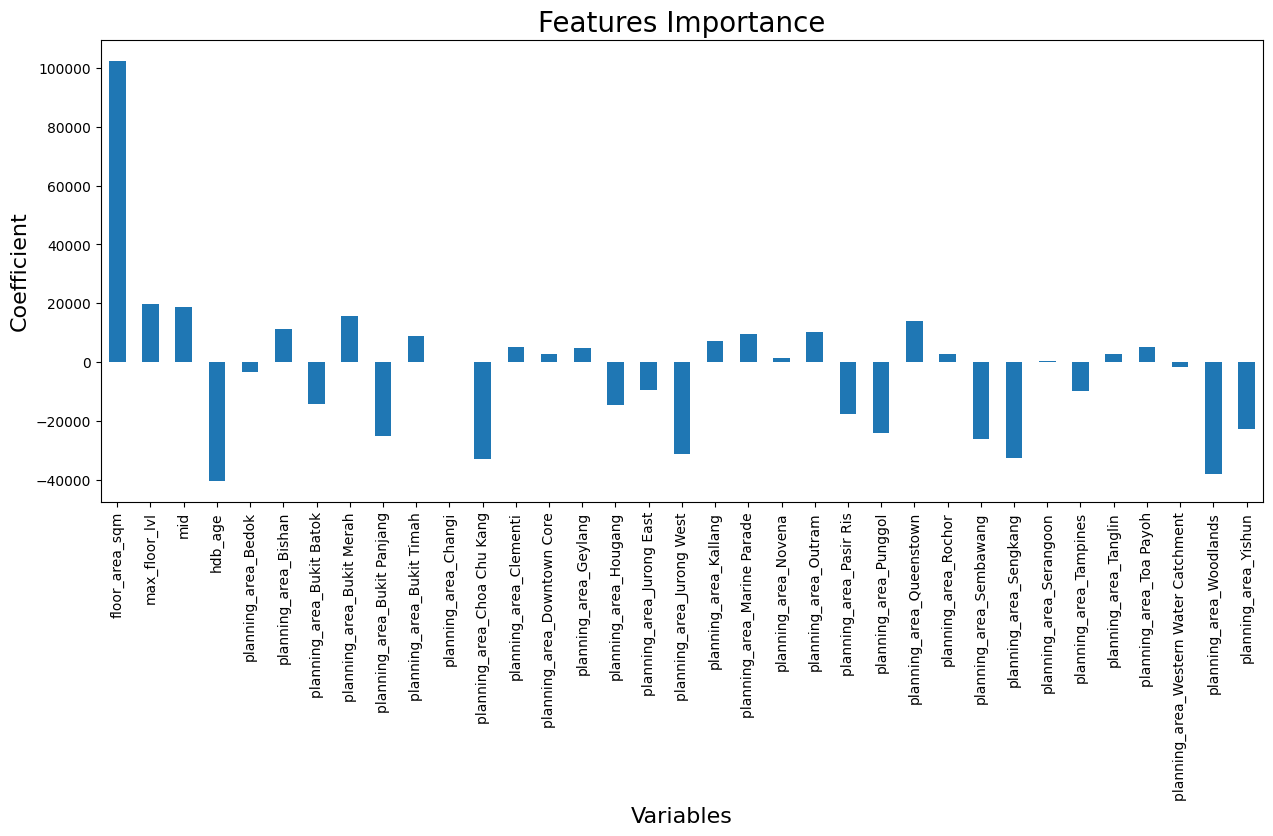

In [12]:
pd.Series(lr.coef_[0], index=x.columns).plot.bar(figsize=(15, 6))
plt.xlabel('Variables',size=16)
plt.ylabel('Coefficient', size=16)
plt.title('Features Importance', size=20)
plt.show()

Looking at the above, it looks like floor area has the largest positive coeficient, which means it has the largest positive impact on HDB resale price.  
Since the input data x is scaled using standard scaler, we can interpret the result that as floor area increase by 1 standard deviation, we should expect the HDB resale price to increase by about 100k.  (This is not the most intuitive interpretation since I did not attempt to scale the coefficient back)  

Meanwhile, the age of the flat has a negative impact on HDB resale price, which make sense as the house gets older, or closer to the 99 years tenor set out by HDB, the less valuable the flat is going to be.  Like the above, we can interpret that as HDB age increase by 1 standard deviation, we should expect the HDB resale price to drop by about 40k.

Interestingly, though unsurprisingly, it looks like the areas such as Choa Chu Kang, Jurong West, Sengkang and Woodlands tend to have negative impact on prices. It also makes sense as these areas locate further away from town.  

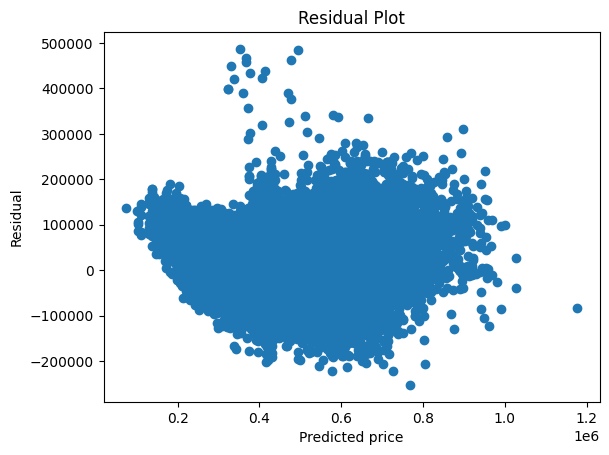

In [13]:
pred = lr.predict(x_test)
residuals = y_test - pred
plt.scatter(pred, residuals)
plt.xlabel('Predicted price')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

No visible pattern can be identified from the above residual plot, indicating the model is capturing most of the information.

In [14]:
mean_squared_error(y_test, pred, squared=False)

60992.97426765514

The model yields a RMSE of about 61k, I would be looking into another model that has more features, in an attempt to improve the RMSE and even R2 score.

#### Kaggle Submission

In [15]:
# Load data

kaggle_test = pd.read_csv('./data/test.csv')
kaggle_test.head()

C:\Users\heziy\AppData\Local\Temp\ipykernel_9172\1903860682.py:3: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_test = pd.read_csv('./data/test.csv')


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


In [16]:
# Select features

kaggle_test = kaggle_test[['id','floor_area_sqm','max_floor_lvl', 'mid', 'hdb_age', 'planning_area']]
kaggle_test = pd.get_dummies(kaggle_test, columns=['planning_area'], drop_first=True)

In [17]:
# seperate out the ID column, and transform the holdout set following the scaler used in training set

kaggle_sub = kaggle_test[['id']]
kaggle_test = kaggle_test.drop('id', axis=1)
kaggle_test = ss.transform(kaggle_test)

In [18]:
# predict the result with Linear Regression model
kaggle_sub['predicted'] = lr.predict(kaggle_test)

In [19]:
# re-index and checkthe format
kaggle_sub = kaggle_sub.set_index(['id'])
kaggle_sub.head()

,predicted
id,
114982,331687.958487
95653,488902.701619
40303,332059.019027
109506,291516.932983
100149,494064.347216


In [20]:
kaggle_sub.to_csv('./data/kaggle_sub1.csv')